# Relax Data Challenge Investigation Notebook

This document has not been prepared with interpretability in mind, but rather as a record of steps taken during analysis. Refer to the [report](https://github.com/gmlander/Springboard/blob/master/Assessments/Relax%20Challenge/Relax_Challenge_Report.ipynb) in this repo for more orderly explaination of results/discoveries.

### Imports, Data Reading, Wrangling, Cleaning

In [39]:
import pandas as pd
import numpy as np
import chardet
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, roc_auc_score

import shap
import lightgbm
%matplotlib inline

In [2]:
engagement = pd.read_csv('data/takehome_user_engagement.csv')

# Errors when trying to read csv without encoding set.
# user chardet module to guess encoding
with open('data/takehome_users.csv', 'rb') as f:
    raw = f.read()
chardet.detect(raw)

{'confidence': 0.7298523315812625, 'encoding': 'ISO-8859-1', 'language': ''}

In [3]:
users = pd.read_csv('data/takehome_users.csv', encoding='ISO-8859-1')

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


### Convert date features to datetime64 format

In [8]:
users['creation_time'] = pd.to_datetime(users.creation_time)

Last session does not have a unit specified. If it's time since epoch in minutes, converting to years yields:

In [9]:
print(1.396e+09/(60*24*365), 'years.')

2656.0121765601216 years.


Whereas for seconds:

In [10]:
print(1.396e+09/(60*60*24*365), 'years.')

44.266869609335366 years.


Since unix is in time since Jan 1, 1970, this is either very hypothetical future data, or data from 2014. Since that is more in line with creation date and basic common sense, will assume seconds.

In [11]:
users['last_session'] = pd.to_datetime(users.last_session_creation_time, unit='s')

engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)

Next, need to identify adopted users as anyone with 3+ visits within 7 days. First step is filter out users that visited fewer than 3 times.

In [12]:
three_visits = engagement.groupby('user_id').visited.count()
three_visits = three_visits[three_visits >= 3]

engagement['visits'] = engagement.user_id.map(three_visits)

engagement = engagement[engagement.visits.notnull()]

# ensure mapping was correct
three_visits.shape[0] == engagement.user_id.nunique()

True

Next part will not be as elegant. Pandas has lots of features for handling datetimes, but none that I know of to do this cleanly. One option would be to make a for loop to go over each user in `engagement` and mark True if 3 visits are seen within a week. For interprettability, this may be the best solution.

Computationally however, it is terrible. Pandas has vectorized operations for a reason after all. Maybe in this case (200k obs) it won't matter too terribly. But better not to build a bad habit for when it does.

In [13]:
# First ensure sort by user and time
engagement.sort_values(by = ['user_id', 'time_stamp'], inplace= True)

# caclulate difference in days for each visit and the one before it.
engagement['since_last']=engagement.groupby('user_id').time_stamp.diff().dt.days

# add each consecutive rows. For cleanliness this should also be done w/ a groupby
# however because of the last groupby operation, there will be a NaN as the first
# entry of 'since_last' for each user, which means this sum operation will not
# accidentally combine information of two different users.
engagement['three_visit_span'] = engagement.since_last.rolling(window=2).sum()

# finally, use this feature to make a referrence series
adopt_status = engagement.groupby('user_id').three_visit_span.min() <= 7

Now simply need to map the new referrence series to users df. Users dropped for having under 3 visits will not be in referrence series and will have NaN value. Fill those with false.

In [14]:
users['adopted'] = users.object_id.map(adopt_status)
users.adopted.fillna(False,inplace=True)
users['adopted'] = users.adopted.astype(int) # coerce to int if space is cheap

## Exploratory Data Analysis

In [15]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.138000
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.344914
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


#### Key takeaways
- 13.8% of users adopted.
- Nearly 25% of last_session is null. This likely means these users created accounts but never actually used the product. It could also be an error with data.
- Nearly half the invited_by_user_id is null. This is understandable, as these users discovered the product organically.
- mailing list and marketing drip are binary discretes / boolean. object_id, ord_id and invited by user id are all categoricals masquerading as numeric types.
- only continous independent variable is last_session creation time. 
- additional non-numeric features are: 'creation_time', 'name', 'email', 'creation_source', and 'last_session'.

Unfortunately, quite a few user id's were removed from engagement to reduce the number of necessary computations. A quick look at the user id's that were all originally in engagement compared to missing last_session users.

In [16]:
test = pd.read_csv('data/takehome_user_engagement.csv')

test.user_id.unique()[:15]

array([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 13, 14, 17, 19, 20, 21], dtype=int64)

In [17]:
users[users.last_session_creation_time.isnull()].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session,adopted
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaT,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaT,0
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0,NaT,0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN,NaT,0
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN,NaT,0


It seems these users were never in the engagement data. But there are users in engagement with only one entry, so the theory that they never logged in seems likely.

Suggests another piece of information from engagement could be of use: visits. While we're at it, might as well add a field referred, which will be a 1 if invited_by_user has a valid entry and a 0 otherwise.

In [18]:
users['visits'] = users.object_id.map(test.groupby('user_id').visited.sum())

users.visits.fillna(0, inplace=True)

users['referred'] = 1
users.loc[users.invited_by_user_id.isnull(), 'referred'] = 0

Another field worth developing is creation source (currently a categorical). Dummifying the entries will add 5 new features.

In [19]:
original_source = users[['object_id', 'creation_source']].copy()
users = pd.get_dummies(users, columns = ['creation_source'], prefix=['source'])

users['creation_source'] = original_source.creation_source

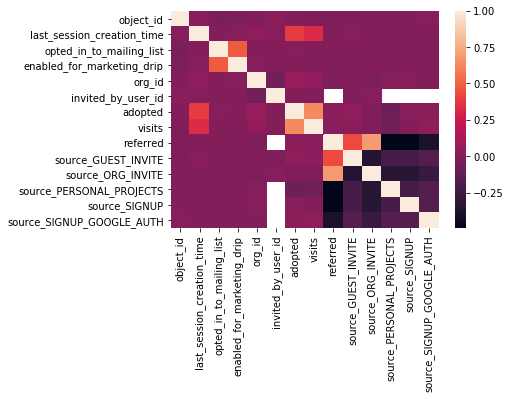

In [20]:
corr = users.corr()
sns.heatmap(corr)

Looks like only correlation to adopted comes from last session time and visits. Both make sense. More recently a user was logged in, more likely user adopted. More visits, more likely they had 3 visits in a week. Neither of these is an especially useful discovery.

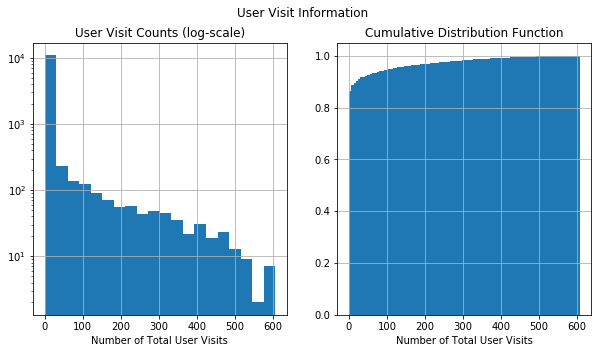

In [21]:
plt.figure(figsize=(10,5))
plt.suptitle('User Visit Information')
plt.subplot(121)
users.visits.hist(bins=20,**{'log':True})
plt.xlabel('Number of Total User Visits')
plt.title('User Visit Counts (log-scale)')

plt.subplot(122)
users.visits.hist(bins=100,**{'cumulative':True,'normed':True})
plt.xlabel('Number of Total User Visits')
plt.title('Cumulative Distribution Function')

plt.savefig('visits.png')

Visit information is interesting. Most users barely use the product, but this who do use it quite a bit.

One more numeric feature to add, `join_lag`, which will be the number of days the account was created after the very first account.

In [22]:
first = users.creation_time.min()
users['join_lag'] = users.creation_time - first

users['join_lag'] = users.join_lag.dt.days

Let's see if this has any effect on adoption.

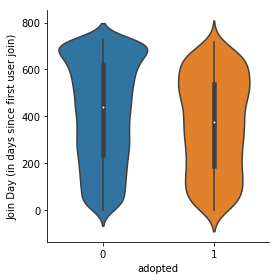

In [23]:
sns.factorplot(x= 'adopted', y='join_lag', data = users, kind = 'violin')
plt.ylabel('Join Day (in days since first user join)')
plt.savefig('join_lag.png')

In [24]:
def rel_pct(x):
    no_adopt = (users.adopted == 0).sum()
    adopt = (users.adopted == 1).sum()
    if x[0] == 0:
        return len(x)/no_adopt
    else:
        return len(x)/adopt

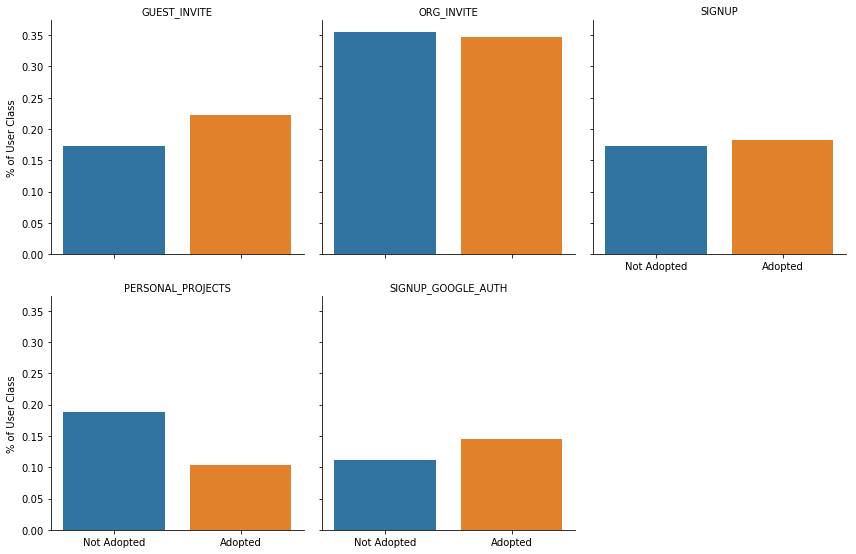

In [25]:
g = sns.factorplot(x='adopted', y='adopted', col = 'creation_source', col_wrap=3,\
                   data = users, kind = 'bar',estimator= rel_pct)

g.set_axis_labels("", "% of User Class").set_xticklabels(["Not Adopted", "Adopted"]).set_titles("{col_name}")

plt.savefig('invite_source.png')

One last thing to include. Email feature can be more than just an index. Can take the email provider and see if there are any trends.

In [26]:
# get email provider
users['email_provider'] = users.email.apply(lambda x: x.split('@')[1])

# get rid of 
users['email_provider'] = users.email_provider.apply(lambda x: x.split('.')[0])

In [27]:
users.email_provider.value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
xvnbr            2
mumdc            2
qgjbc            2
Name: email_provider, dtype: int64

In [28]:
emails = users.email_provider.value_counts()
big_emails = emails[emails > 3].index

In [29]:
users.loc[~users.email_provider.isin(big_emails), 'email_provider'] = 'other'

In [30]:
orig_emails = users[['object_id', 'email_provider']].copy()

In [31]:
users = pd.get_dummies(users, columns=['email_provider'], prefix='email_is')
users['email_provider'] = orig_emails.email_provider

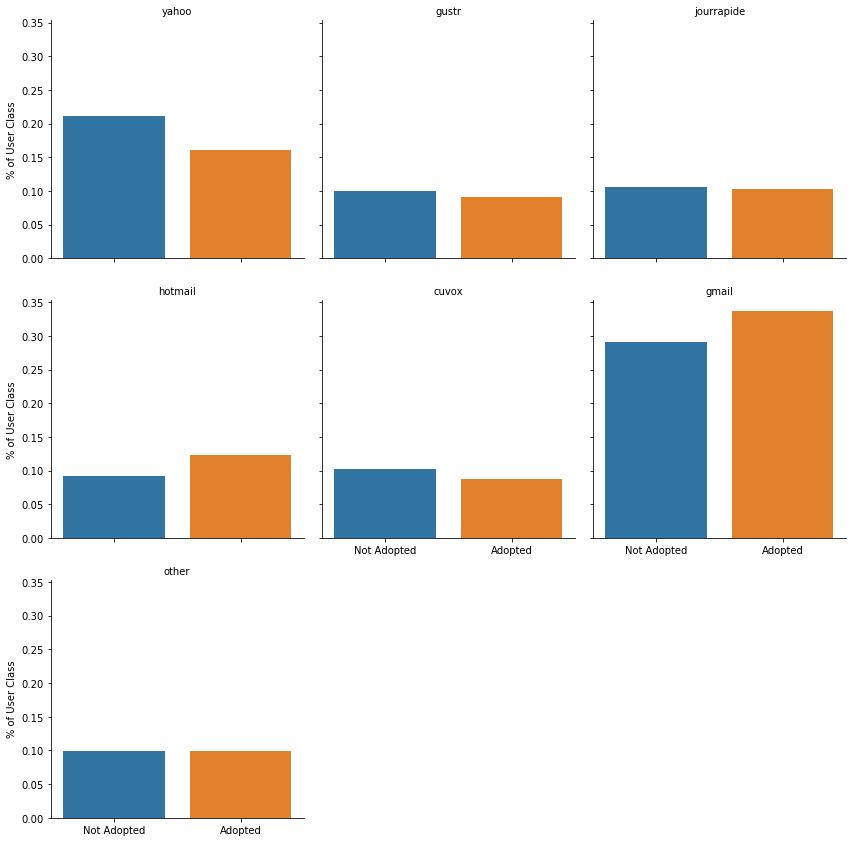

In [32]:
g = sns.factorplot(x='adopted', y='adopted', col = 'email_provider', col_wrap=3,\
                   data = users, kind = 'bar',estimator= rel_pct)

g.set_axis_labels("", "% of User Class").set_xticklabels(["Not Adopted", "Adopted"]).set_titles("{col_name}")

plt.savefig('email.png')

**COOL!** A feature not readily available in the original data is actually providing some useful information about the target. Gmail and hotmail users are more likely to adopt. Yahoo users are least likely to adopt.

One last feature that might be useful, `invited_by_user_id`. Use this to create a feature for whether the user was invited by an adopted user or not.

In [40]:
users['adopted_inviter'] = users.invited_by_user_id.map(adopt_status).fillna(False).astype(int)

In [41]:
users[users.adopted_inviter == 0].adopted.mean(), users[users.adopted_inviter == 1].adopted.mean()

(0.1304067734216823, 0.21075837742504408)

As I'd hoped to find. Users invited by adopted users were much more likely to join than those that weren't.

### Feature selection

The following will not be used for modeling:
- Identifying features like name/email
- `adopted` (target variable)
- Datetime features
- Categoricals
- Features beyond a company's control (last session creation time, visits). If the product team had a way to change those features we wouldn't be trying to solve the problem. Yes, join lag is also beyond the team's control, but it is not connected to the target variable in the same way visits and last sesssion are - meaning there is a possibility for recommendations that may improve adoption based on when a user joins.

In [42]:
ignore_cols = ['object_id', 'creation_time', 'name', 'email','last_session_creation_time',
               'org_id', 'invited_by_user_id','last_session', 'adopted', 'visits',
               'creation_source', 'email_provider', 'join_lag']

## Model Building

The goal is to:

>   "**identify  which  factors  predict  future  user adoption**"

This means accuracy is not as important as interprettability and explainablity. The go to for this is usually logistic regression. But... I've done a bunch of that and want to try something new. There's a new package, [shap](https://github.com/slundberg/shap), which interprets a model against its data to evaluate how each factored informed the model. Worth checking out! I'll use AdaBoost with a stump tree as the model.

I'll also do a regular decision tree and see how it compares.

In [43]:
x, x_test, y, y_test = train_test_split(users.drop(ignore_cols, axis=1), users.adopted,test_size=.3)

### AdaBoost

In [44]:
# make adaboosted decision stump
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200, random_state=7)
ada.fit(x, y)
ada_train_score = ada.score(x,y)
ada_test_score = ada.score(x_test,y_test)

In [45]:
print("Training accuracy: {:0.4f}\nTesting accuracy: {:0.4f}".format(ada_train_score, ada_test_score))

Training accuracy: 0.8642
Testing accuracy: 0.8569


### LightGBM

In [46]:
train_data=lightgbm.Dataset(x,label=y)

In [47]:
param = {'num_leaves':250, 'objective':'binary','max_depth':15,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

In [48]:
lgb = lightgbm.train(param,train_data,num_boost_round = 70)

In [49]:
def pred_labels(model, data):
    pred = model.predict(data)
    pred[pred >= .5] = 1
    pred[pred < .5] = 0
    return pred

In [50]:
lgb_train_score = accuracy_score(y, pred_labels(lgb, x))
lgb_test_score = accuracy_score(y_test, pred_labels(lgb, x_test))
print("Training accuracy: {:0.4f}\nTesting accuracy: {:0.4f}".format(lgb_train_score, lgb_test_score))

Training accuracy: 0.8645
Testing accuracy: 0.8572


No improvement over AdaBoost. Probably can get better with hyperparameter tuning, but again, accuracy isn't the main goal.

## Interpretation
---

### Feature Importances

**AdaBoost**

In [51]:
pd.Series(ada.feature_importances_, index=x.columns).sort_values(ascending=False)[:10]

source_SIGNUP_GOOGLE_AUTH     0.080
email_is_jourrapide           0.060
opted_in_to_mailing_list      0.060
email_is_gmail                0.060
email_is_cuvox                0.055
source_PERSONAL_PROJECTS      0.055
email_is_other                0.050
enabled_for_marketing_drip    0.050
adopted_inviter               0.045
email_is_hotmail              0.040
dtype: float64

**LightGBM**

In [52]:
pd.Series(lgb.feature_importance(), index=x.columns).sort_values(ascending=False)[:10]

opted_in_to_mailing_list      1429
enabled_for_marketing_drip    1271
email_is_gmail                 695
referred                       536
email_is_cuvox                 484
source_GUEST_INVITE            392
email_is_jourrapide            375
email_is_gustr                 349
email_is_other                 311
email_is_hotmail               272
dtype: int32

Neither of those is super useful. No directions, only magnitudes. Is join_lag good or bad? Only know it's important. Need a better way...

### SHAP

---

**AdaBoost**

In [53]:
f = lambda x: ada.predict_proba(x)[:,1]
med = x.median().values.reshape((1,x.shape[1]))
explainer = shap.KernelExplainer(f, med)

In [446]:
shap_values = explainer.shap_values(x_test)

100%|██████████████████████████████████████| 3600/3600 [03:19<00:00, 18.02it/s]


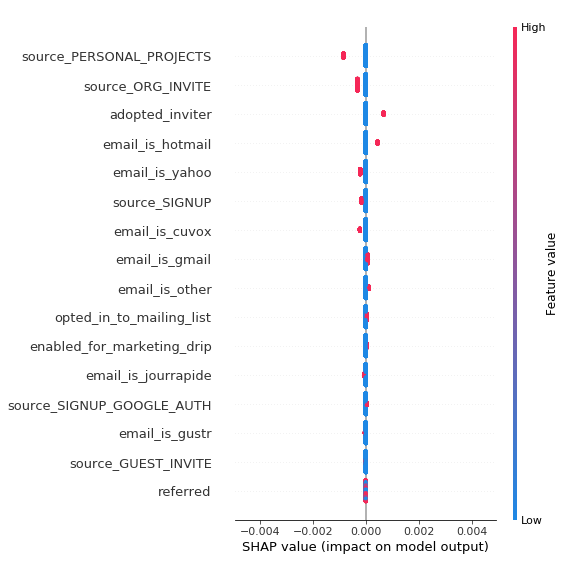

In [457]:
shap.summary_plot(shap_values, x_test)

In [493]:
shap.force_plot(shap_values[0,:], x_test.iloc[0,:])

**LightGBM**

In [454]:
lgb_shap_values = lgb.predict(x_test.as_matrix(), pred_contrib=True)

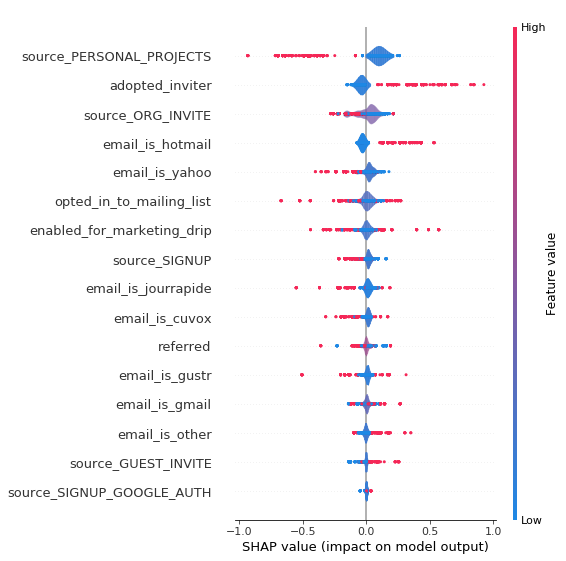

In [458]:
shap.summary_plot(lgb_shap_values, x_test, plot_type='violin')
plt.savefig('lgb_feats.png')

In [462]:
shap.initjs()

In [476]:
shap.force_plot(lgb_shap_values[:1,:], x_test.iloc[:1,:])

In [489]:
shap.force_plot(lgb_shap_values[57,:], x_test.iloc[57,:])

### Conclusion

SHAP is adding some context to feature importances. Force plots are not working well for AdaBoost because it's only showing the decision function of the chosen stump tree for the observation.

The summary plots can be hard to interpret at first, but give a lot of information. Higher values of a variable are encoded as red, lower as blue. For binary features that means red when true blue when false.

**Positive predictors**:
- *Strong Effect*
    - The user was invited by another adopted user
    - The user has a hotmail account


- *Weak Effect*
    - Email is gmail or 'other'.
    - Opted into mailing list
    - Enabled marketing drip
    - Signed up through Google authentication

**Negative predictors**:
- *Strong effect*
    - The user created their account for a personal project or by an organization invite.  

  
- *Weak effect*
    - Email is yahoo or cuvox
    - Creation source is 'signup'